# CSE 7324 Lab Assignment Five:  Wide and Deep Network Architectures
Minging Li, Jiayin Liu, Tianlei Xu, He Zhou  
  Apr.15, 2018

# 1. Preparation and Overview

## 1.1 Business Understanding

The data used in this assignment represents a random sample of abalone from the Tasmanian Coastline, which was from a study initiated by the Tasmanian Aquaculture and Fisheries Institute. The goal of the study was to investigate the growth patterns of abalone living along the Tasmanian coastline. We obtained the dataset through UCI Machine Learning Repository (1). 

The classification task is to predict the rings (an indicator of age, rings + 1.5 gives the age in years) of abalone from various physical measurements. In this study, rings are treated as a 3-category classification problem (grouping rings classes 1-8, 9-12, and 13 on). Rings numbered 1-8 usually represent to infant abalone. Traditionally, the age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope, which is a boring and time-consuming task. If other measurements, such as weight, height and length, which are easier to obtain, can be used to predict the age, the estimation of abalone ages would be a much easier task. Additional, the harvest of abalone is restricted by both the number and size limit of abalone that can be caught. The restriction is an effective way to control the population of abalone. An accurate model could provide a simple way to tell the age of abalone based on their various measurements. This would be helpful for Tasmanian officials to develop rules on the size of abalone harvest. 

## 1.2 Data Pre-processing

** The class variable : rings(indicator of age) ** -- we use number to present diiferent levels of the rings: '0': rings from 1 to 8 which represents the infant ones  '1': rings from 9 to 12 which represents the  mature one. '2': rings beyond 13 which represents the old ones.

In [26]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings
from keras.utils import np_utils
from sklearn import metrics as mt
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Merge, concatenate
from keras.models import Model
from copy import deepcopy 
warnings.filterwarnings("ignore")

# load the Abalone dataset
df = pd.read_excel('D:/Abalone.xlsx')
# create numrical indicator for each feature
# '0': 1-8 infant   '1': 9-12 meature   '2': 13+ old
df['Rings'] = pd.cut(df['Rings'],[0,8,12,1e6],
                                 labels=['1-8','9-12','13+']) # this creates a new variable
df.Rings.replace(to_replace = ['1-8','9-12', '13+'],
                   value = range(3), inplace = True)
# '0':   light   '1': medium   '2': heavy   '3':very heavy
df['Shucked_weight'] = pd.cut(df['Shucked_weight'],[0,0.2,0.4,0.7,2],
                                 labels=['light','medium','heavy','very heavy']) 
#df.Shucked_weight.replace(to_replace = ['light','medium','heavy','very heavy'],
                 #value = range(4), inplace = True)
# '0':   light   '1': medium   '2': heavy   '3':very heavy
df['Shell_weight'] = pd.cut(df['Shell_weight'],[0,0.15,0.3,0.5,2],
                                 labels=['light','medium','heavy','very heavy']) 
#df.Shell_weight.replace(to_replace = ['light','medium','heavy','very heavy'],
                 #value = range(4), inplace = True)
# convert sex to numrical indicator
# F: female, M: Male, I:infant(the infant abalone haven't form the feature of sex)
#df['Sex'] = df.Sex.replace(to_replace=['F','M','I'],
                          #value = range(3))

** Final Dataset Description **

|Variable | description| scale|
|----|--------|-----|
|length:      |longest shell measurement | ratio|
|diameter:      |perpendicular to length| ratio|
|height:      |with meat viscera in shell| ratio|
|whole weight:  |whole abalone| ratio|
|shucked weight: |weight of meat in shell| nominal|
|viscera weight:    |gut weigth| ratio|
|shell weight :   |weight after being dried| nominal|
|sex:            |sex of abalone: Female, Male, Infant| nominal|

## 1.3 Cross-product Features

Here, based on the features we can get from the dataframe, to get cross-product features, we need to think about the potential relation between different features. Whether the comnination has meaning? Whether different variables in cross-product have obvious differences? From these key points, start to think from our background. Because the reason of reproducing, different sex of abalone could have great difference on the shucked weight and shell weight. Though they may have the same rings, but heir weight could have great distiguish on it. Also, the infant could be the effect factor here. So, the interaction terms `Sex X Shucked weight` and ` Sex X Shell weight` were incorporated. Other features, because any pair of two in them may not have tight connection, so we don't create other cross-product here.

In [5]:
categorical_headers=[]
categorical_headers.append('Sex')
categorical_headers.append('Shell weight')
categorical_headers.append('Shucked weight')
print("categorical features:\n", categorical_headers)
print("crossed column:", 
      "\n     [('Shell weight', 'sex'),('Shucked weight', 'sex')")

categorical features:
 ['Sex', 'Shell weight', 'Shucked weight']
crossed column: 
     [('Shell weight', 'sex'),('Shucked weight', 'sex')


## 1.4 Evaluation Metric

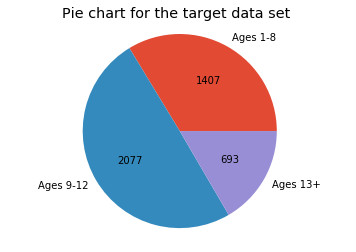

Number of instances in the classification problem: 4177


In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# plot a pie chart of classes
labels = "Ages 1-8", "Ages 9-12", "Ages 13+"
Rings = df['Rings']
sizes = [sum(Rings == 0), sum(Rings == 1), sum(Rings == 2)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct=lambda p: '{:.0f}'.format(p * len(df.Rings) / 100))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pie chart for the target data set ')
plt.show()

print('Number of instances in the classification problem:', len(df.Rings))

As we can see from the pie chart of our target rings, the class sizes are extremely unbalanced, if we continue to use accuracy as our evaluation metric, the result may different from what we expect. The accuracy evaluated the true negatives equally with the true postitives. However, different with that, here we care more about the algorithm correctly classfied a particulat class. So, we don't use accuracy here while we choose ** F1 score** as our scorer, which is an average evalution of the precision and the recall. 

The F1 score has two methods to get such average statistic of information retrieval and classification: Micro-average method and Macro-average method.In Micro-average method, we sum up the individual true positives,false positives, and false negatives of the system for different sets and the apply them to get the statistics; In Macro-average method, we take the average of the F1 score of the system on different sets.

The difference between two methods is that, the former weights all classes equally, so it is usually used when we want to know how the system performs overall across the sets of data. Comparing to this, while the micro-average method, which weights all instances equally, can be a useful measure when your dataset varies in size. So, here, we choose micro-average as our evaluation metric.

In [7]:
from sklearn.metrics import make_scorer,f1_score

# make f1 micro our scorer
scorer = make_scorer(f1_score, average='micro', pos_label=1, greater_is_better = True)

## 1.5 Data Spliting

To get better result, we decide to do cross validation on the train set first, then use the model on the test set to check the performance of the model by looking into the scores. We use stratifiedly splitting to create 10 pairs of train sets and test sets. The validation score provides the performance of the model on external data, therefore it is useful information free from data snooping. In comparing the performance of different deep network architectures to obtain our best model, we calculated the pair-metric differences and its corresponding confidence interval. 

When we compare the performance of our best wide and deep network to standard multi-layer perceptron, we use the receiver operating characteristic and area under the curve. The evaluation result from each fold genearlly gives us an overall idea about the performace of each model when we conduct the model comparison.

In [8]:
from sklearn.cross_validation import StratifiedKFold

df.reset_index(inplace=True)
# split our data into train and test sets 
# shuffle-split 10 times
K = 10
kfold = StratifiedKFold(y=df['Rings'].values, n_folds=K, random_state=1)

# 2.Modeling
## 2.1 Wide and Deep Network

In [9]:
from sklearn.preprocessing import OneHotEncoder
def wide_deep_4(cross_columns,df_train, df_test):

    # we need to create separate lists for each branch
    encoders = dict() 
    categorical_headers = ['Sex','Shucked_weight','Shell_weight']

    # train all encoders (special case the target 'income')
    for col in categorical_headers+['Rings']:
        #df_train[col] = df_train[col].str.strip()
        #df_test[col] = df_test[col].str.strip()

        if col=="Rings":
            tmp = LabelEncoder()
            df_train[col] = tmp.fit_transform(df_train[col])
            df_test[col] = tmp.transform(df_test[col])
        else:
            # integer encoded variables
            encoders[col] = LabelEncoder()
            df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
            df_test[col+'_int'] = encoders[col].transform(df_test[col])

    # scale the numeric, continuous variables
    numeric_headers = ["Length", "Diameter", "Height","Whole_weight", "Viscera_weight"]

    for col in numeric_headers:
        df_train[col] = df_train[col].astype(np.float)
        df_test[col] = df_test[col].astype(np.float)

        ss = StandardScaler()
        df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
        df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))
    categorical_headers_ints = [x+'_int' for x in categorical_headers]
    # we will forego one-hot encoding right now and instead just scale all inputs
    feature_columns = categorical_headers_ints+numeric_headers
    X_train =  ss.fit_transform(df_train[feature_columns].values).astype(np.float32)
    X_test =  ss.transform(df_test[feature_columns].values).astype(np.float32)

    y_train = df_train['Rings'].values.astype(np.int)
    y_train = np_utils.to_categorical(y_train)

    y_test = df_test['Rings'].values.astype(np.int)
    y_test = np_utils.to_categorical(y_test)
    
    ohe = OneHotEncoder()
    X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
    X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

    # and save off the numeric features
    X_train_num =  df_train[numeric_headers].values
    X_test_num = df_test[numeric_headers].values
    
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []

    for cols in cross_columns:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()

        # create crossed labels
        X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)

        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)

    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=3,activation='sigmoid',name='wide_combined')(wide_branch)

    # reset this input branch
    all_deep_branch_outputs = []
    # add in the embeddings
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( df_train[col].values )
        X_ints_test.append( df_test[col].values )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)
    ######################################################################################################## 
    # also get a dense branch of the numeric features
    all_inputs.append(Input(shape=(X_train_num.shape[1],),
                            sparse=False,
                            name='numeric_data'))

    x = Dense(units=8, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append( x )

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units= 24,activation='relu', name='deep4')(deep_branch)
    deep_branch = Dense(units= 12,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units= 8,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units= 6,activation='relu', name='deep3')(deep_branch)

    final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    final_branch = Dense(units=3,activation='sigmoid',name='combined')(final_branch)

    model = Model(inputs=all_inputs, outputs=final_branch)
    
    model.compile(optimizer='Adam',
              loss='mean_squared_error',
              metrics=['accuracy'])
    
    history = model.fit(X_ints_train+ [X_train_num],
                    y_train, 
                    epochs=10,
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_num], y_test))
    
    yhat = np.round(model.predict(X_ints_test + [X_test_num]))                 # 得到yhat
    
    print(mt.confusion_matrix(y_test.argmax(axis = 1), yhat.argmax(axis = 1)))  # confusion matrix
    
    from matplotlib import pyplot as plt

    

    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    plt.plot(history.history['acc'])

    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(history.history['val_acc'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    
    
    
    return mt.accuracy_score(y_test,yhat),yhat

## 2.2 Getting 'history'

Train on 3758 samples, validate on 419 samples
Epoch 1/10
3758/3758 [==============================] - 2s 526us/step - loss: 0.2099 - acc: 0.4718 - val_loss: 0.1734 - val_acc: 0.5895
Epoch 2/10
3758/3758 [==============================] - 0s 79us/step - loss: 0.1608 - acc: 0.6647 - val_loss: 0.1587 - val_acc: 0.6420
Epoch 3/10
3758/3758 [==============================] - 0s 72us/step - loss: 0.1522 - acc: 0.6722 - val_loss: 0.1504 - val_acc: 0.6874
Epoch 4/10
3758/3758 [==============================] - 0s 76us/step - loss: 0.1490 - acc: 0.6695 - val_loss: 0.1496 - val_acc: 0.6874
Epoch 5/10
3758/3758 [==============================] - 0s 78us/step - loss: 0.1467 - acc: 0.6711 - val_loss: 0.1507 - val_acc: 0.6945
Epoch 6/10
3758/3758 [==============================] - 0s 84us/step - loss: 0.1444 - acc: 0.6804 - val_loss: 0.1504 - val_acc: 0.6874
Epoch 7/10
3758/3758 [==============================] - 0s 84us/step - loss: 0.1428 - acc: 0.6801 - val_loss: 0.1504 - val_acc: 0.6897
Epoch 8

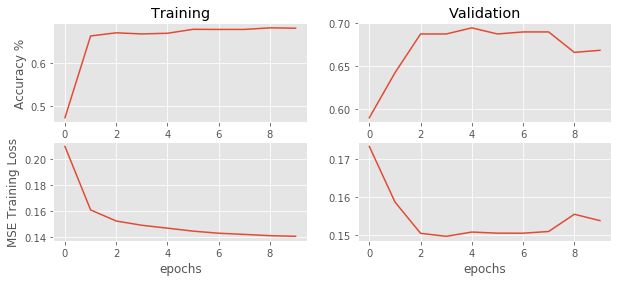

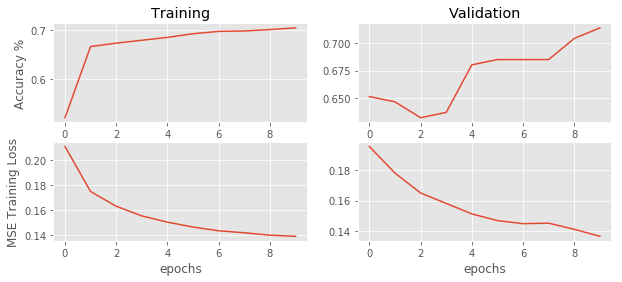

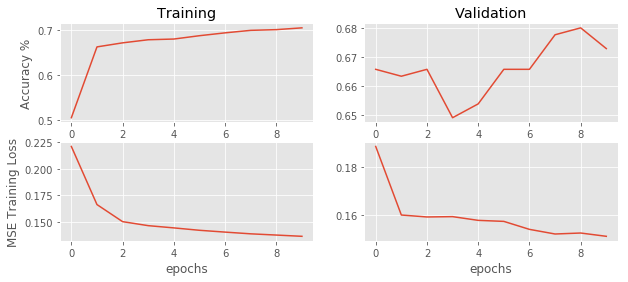

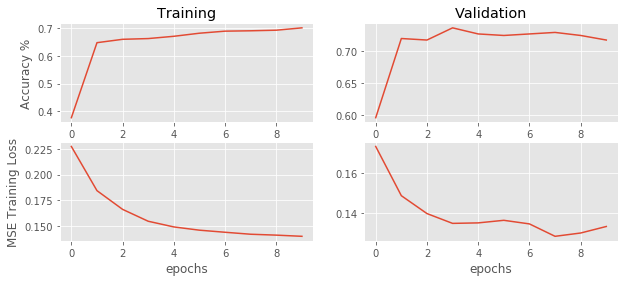

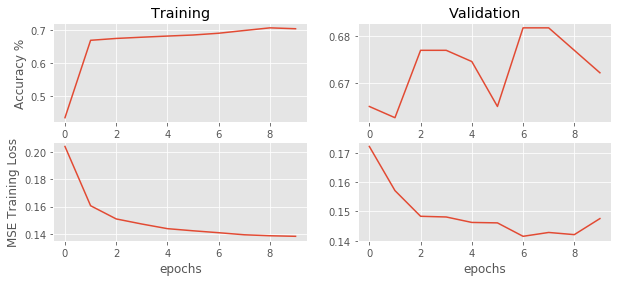

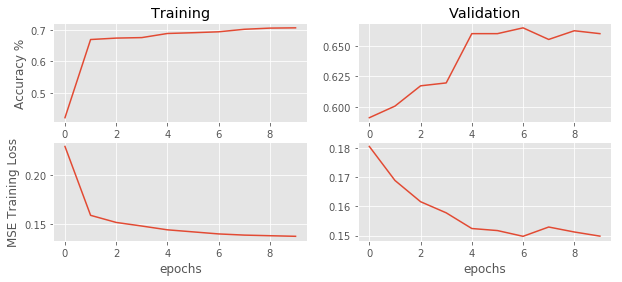

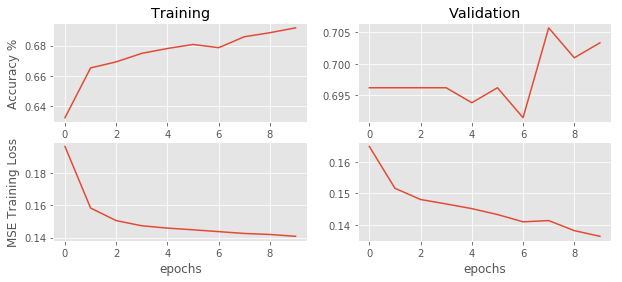

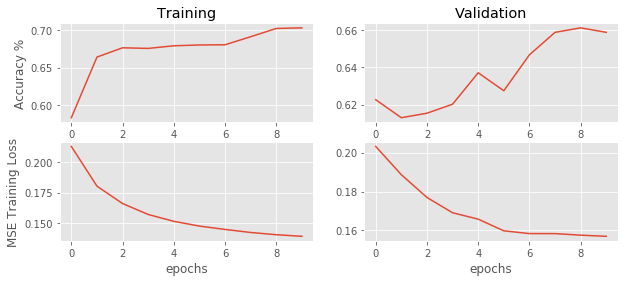

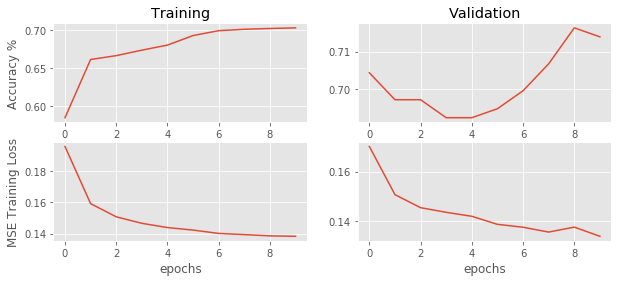

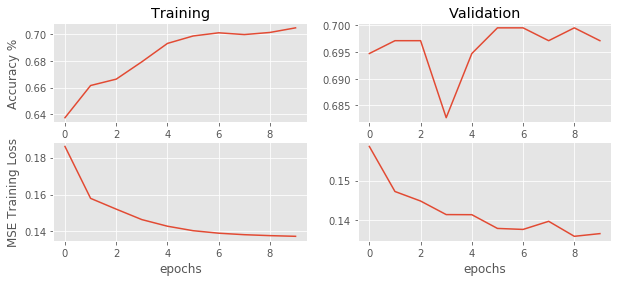

In [27]:
accuracy = 0 
mlp_proba_4 = []       # 创建一个list存储每份数据得到的yhat
for k, (train, test) in enumerate(kfold):
    X_train = df.iloc[train]
    X_test = df.iloc[test]
    a, yhat = wide_deep_4([['Sex','Shucked_weight','Shell_weight'], ['Shucked_weight','Shell_weight']],X_train, X_test)
    accuracy += a 
    mlp_proba_4.append(yhat)    
#The graph is at the bottom. We also take the screenshot in the following cell.

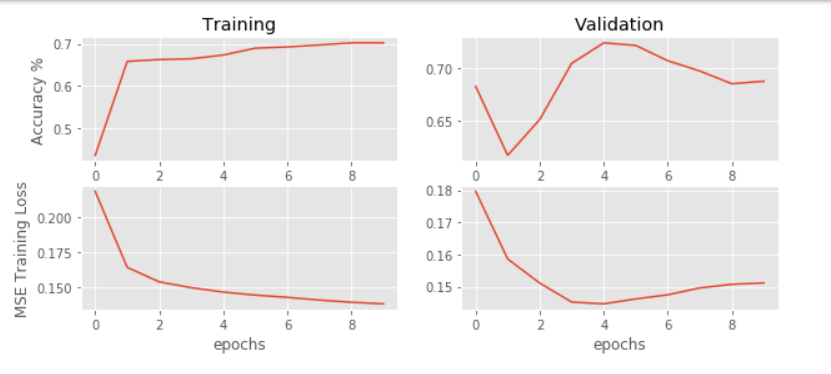
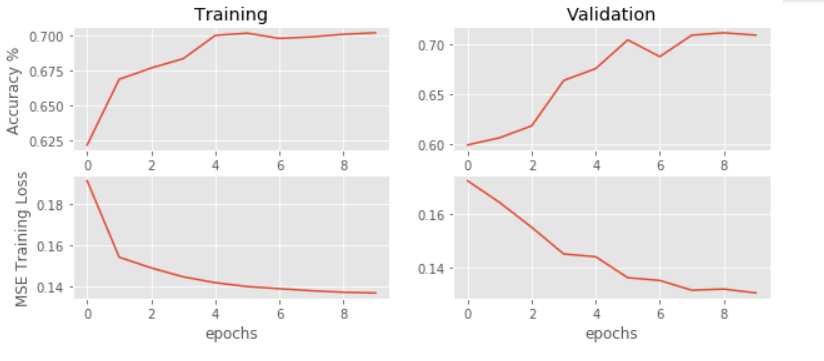
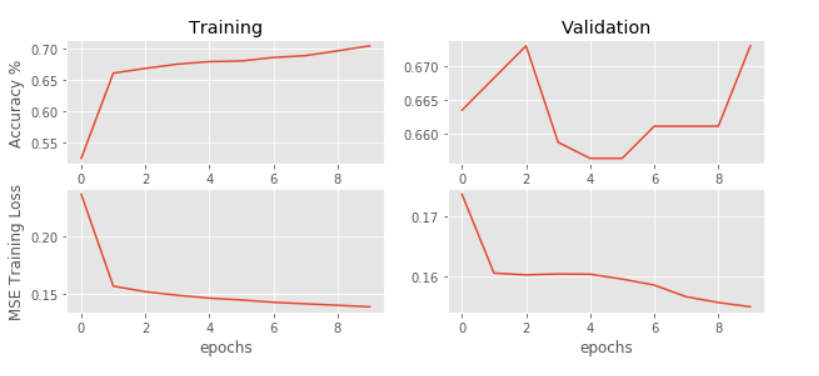
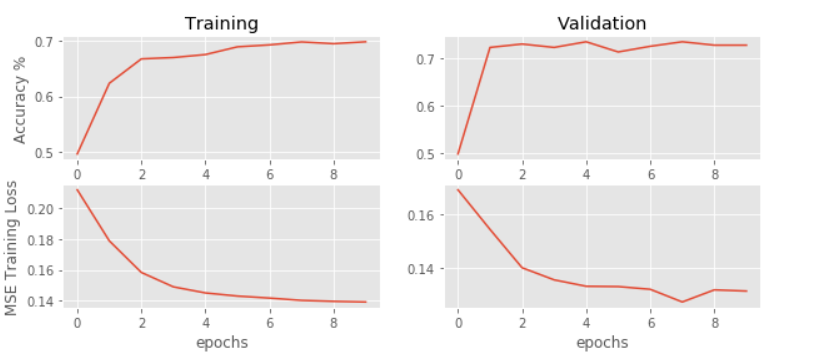
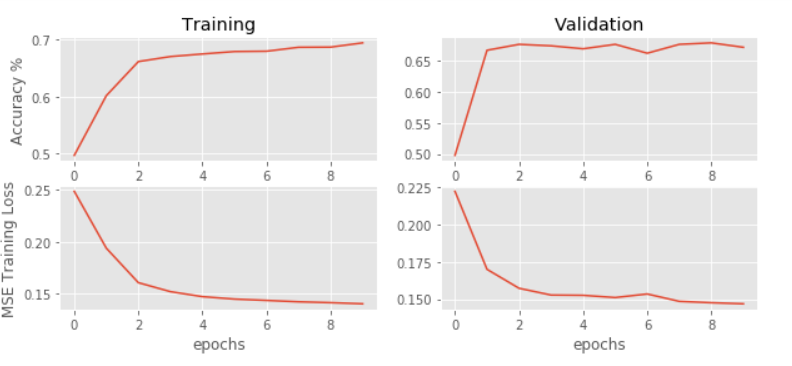
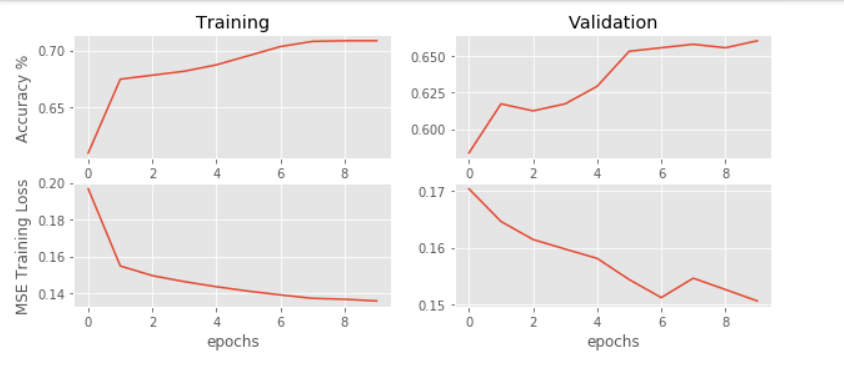
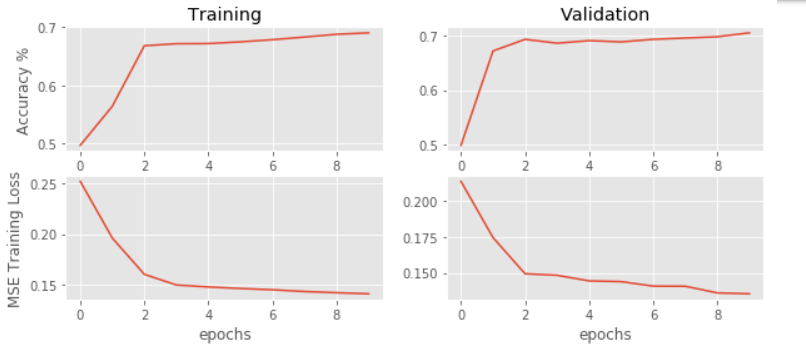
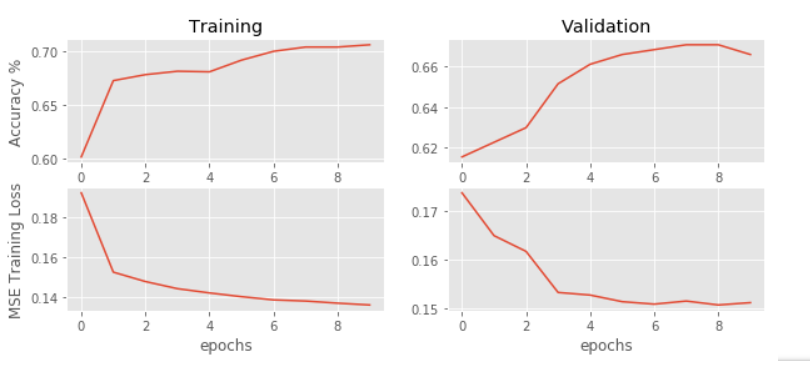
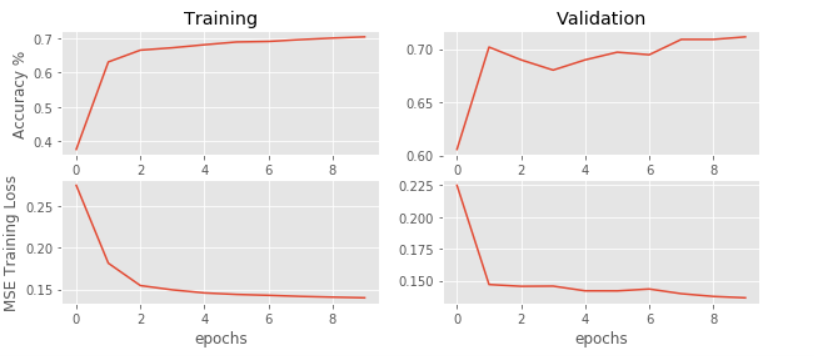
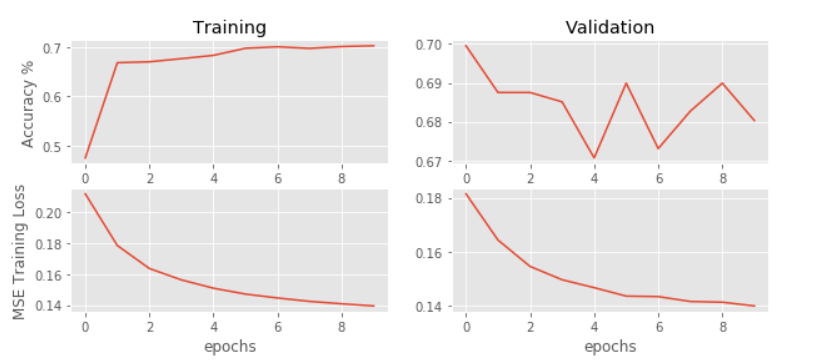

In [11]:
accuracy = accuracy / 10
accuracy

0.64306311230535584

## 2.3 Create different number of layers

In [12]:
def wide_deep_3(cross_columns,df_train, df_test):

    # we need to create separate lists for each branch
    encoders = dict() 
    categorical_headers = ['Sex','Shucked_weight','Shell_weight']

    # train all encoders (special case the target 'income')
    for col in categorical_headers+['Rings']:
        #df_train[col] = df_train[col].str.strip()
        #df_test[col] = df_test[col].str.strip()

        if col=="Rings":
            tmp = LabelEncoder()
            df_train[col] = tmp.fit_transform(df_train[col])
            df_test[col] = tmp.transform(df_test[col])
        else:
            # integer encoded variables
            encoders[col] = LabelEncoder()
            df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
            df_test[col+'_int'] = encoders[col].transform(df_test[col])

    # scale the numeric, continuous variables
    numeric_headers = ["Length", "Diameter", "Height","Whole_weight", "Viscera_weight"]

    for col in numeric_headers:
        df_train[col] = df_train[col].astype(np.float)
        df_test[col] = df_test[col].astype(np.float)

        ss = StandardScaler()
        df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
        df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))
    categorical_headers_ints = [x+'_int' for x in categorical_headers]
    # we will forego one-hot encoding right now and instead just scale all inputs
    feature_columns = categorical_headers_ints+numeric_headers
    X_train =  ss.fit_transform(df_train[feature_columns].values).astype(np.float32)
    X_test =  ss.transform(df_test[feature_columns].values).astype(np.float32)

    y_train = df_train['Rings'].values.astype(np.int)
    y_train = np_utils.to_categorical(y_train)

    y_test = df_test['Rings'].values.astype(np.int)
    y_test = np_utils.to_categorical(y_test)
    
    ohe = OneHotEncoder()
    X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
    X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

    # and save off the numeric features
    X_train_num =  df_train[numeric_headers].values
    X_test_num = df_test[numeric_headers].values
    
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []

    for cols in cross_columns:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()

        # create crossed labels
        X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)

        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)

    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=3,activation='sigmoid',name='wide_combined')(wide_branch)

    # reset this input branch
    all_deep_branch_outputs = []
    # add in the embeddings
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( df_train[col].values )
        X_ints_test.append( df_test[col].values )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)
    ######################################################################################################## 
    # also get a dense branch of the numeric features
    all_inputs.append(Input(shape=(X_train_num.shape[1],),
                            sparse=False,
                            name='numeric_data'))

    x = Dense(units=8, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append( x )

    # merge the deep branches together
    
    
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    ############################################################################################
    deep_branch = Dense(units= 12,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units= 8,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units= 6,activation='relu', name='deep3')(deep_branch)
    ############################################################################################
    final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    final_branch = Dense(units=3,activation='sigmoid',name='combined')(final_branch)

    model = Model(inputs=all_inputs, outputs=final_branch)
    
    model.compile(optimizer='Adam',
              loss='mean_squared_error',
              metrics=['accuracy'])
    
    history = model.fit(X_ints_train+ [X_train_num],
                    y_train, 
                    epochs=10,
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_num], y_test))
    
    yhat = np.round(model.predict(X_ints_test + [X_test_num]))                 # 得到yhat
    
    print(mt.confusion_matrix(y_test.argmax(axis = 1), yhat.argmax(axis = 1)))  # confusion matrix
    
    from matplotlib import pyplot as plt

    

    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    plt.plot(history.history['acc'])

    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(history.history['val_acc'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    
    
    
    return mt.accuracy_score(y_test,yhat),yhat

Train on 3758 samples, validate on 419 samples
Epoch 1/10
3758/3758 [==============================] - 1s 369us/step - loss: 0.2605 - acc: 0.4098 - val_loss: 0.2393 - val_acc: 0.4916
Epoch 2/10
3758/3758 [==============================] - 0s 59us/step - loss: 0.1979 - acc: 0.6086 - val_loss: 0.1689 - val_acc: 0.6325
Epoch 3/10
3758/3758 [==============================] - 0s 64us/step - loss: 0.1577 - acc: 0.6626 - val_loss: 0.1584 - val_acc: 0.6325
Epoch 4/10
3758/3758 [==============================] - 0s 60us/step - loss: 0.1530 - acc: 0.6676 - val_loss: 0.1550 - val_acc: 0.6468
Epoch 5/10
3758/3758 [==============================] - 0s 60us/step - loss: 0.1499 - acc: 0.6692 - val_loss: 0.1499 - val_acc: 0.6730
Epoch 6/10
3758/3758 [==============================] - 0s 60us/step - loss: 0.1470 - acc: 0.6711 - val_loss: 0.1480 - val_acc: 0.6754
Epoch 7/10
3758/3758 [==============================] - 0s 59us/step - loss: 0.1447 - acc: 0.6764 - val_loss: 0.1501 - val_acc: 0.6754
Epoch 8

Epoch 8/10
3759/3759 [==============================] - 0s 65us/step - loss: 0.1420 - acc: 0.6919 - val_loss: 0.1566 - val_acc: 0.6531
Epoch 9/10
3759/3759 [==============================] - 0s 61us/step - loss: 0.1411 - acc: 0.6994 - val_loss: 0.1567 - val_acc: 0.6507
Epoch 10/10
3759/3759 [==============================] - 0s 64us/step - loss: 0.1404 - acc: 0.7005 - val_loss: 0.1535 - val_acc: 0.6531
[[102  38   1]
 [ 43 156   9]
 [  4  51  14]]
Train on 3759 samples, validate on 418 samples
Epoch 1/10
3759/3759 [==============================] - 2s 451us/step - loss: 0.2392 - acc: 0.3631 - val_loss: 0.1928 - val_acc: 0.4976
Epoch 2/10
3759/3759 [==============================] - 0s 66us/step - loss: 0.1870 - acc: 0.5847 - val_loss: 0.1754 - val_acc: 0.6435
Epoch 3/10
3759/3759 [==============================] - 0s 63us/step - loss: 0.1721 - acc: 0.6627 - val_loss: 0.1612 - val_acc: 0.6890
Epoch 4/10
3759/3759 [==============================] - 0s 63us/step - loss: 0.1590 - acc: 0.66

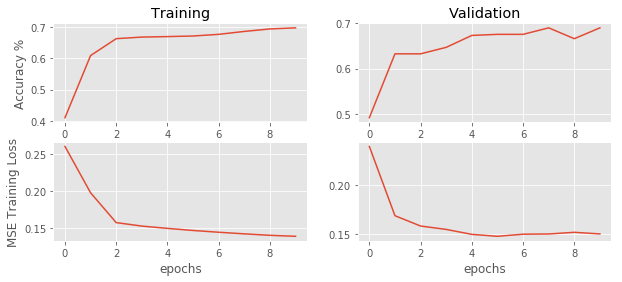

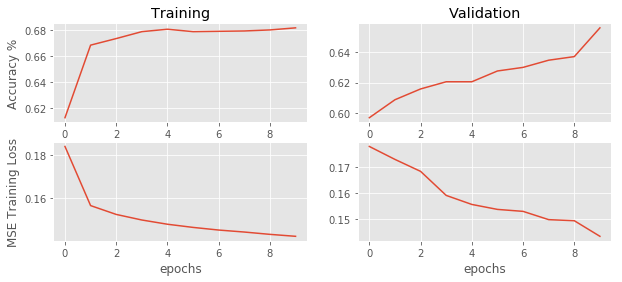

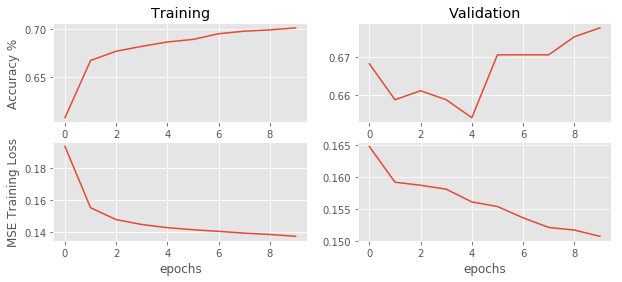

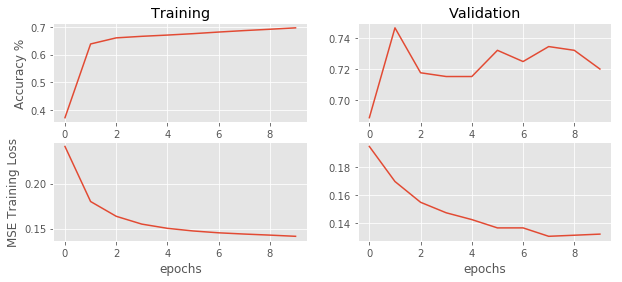

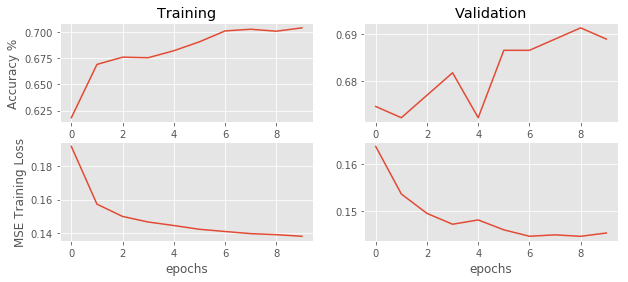

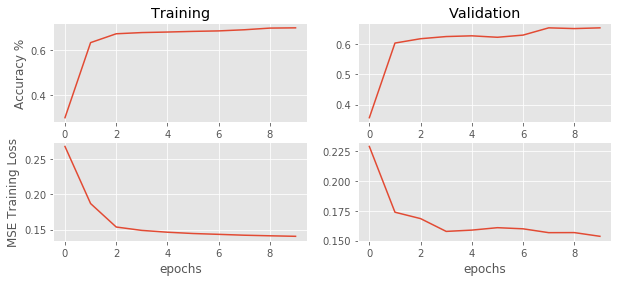

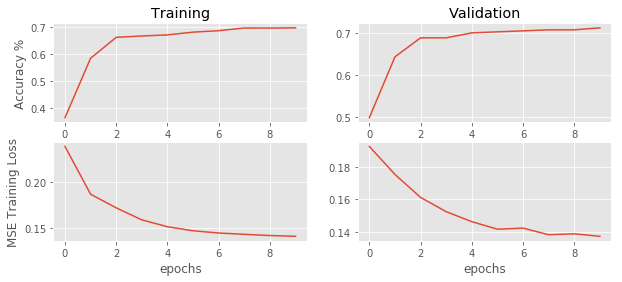

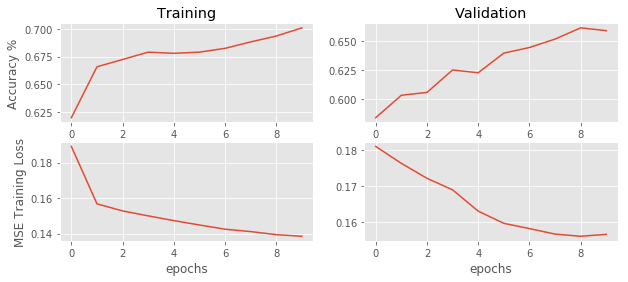

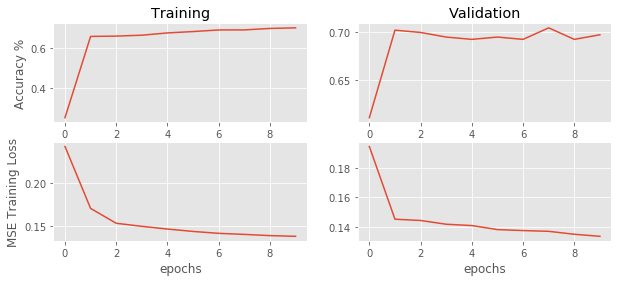

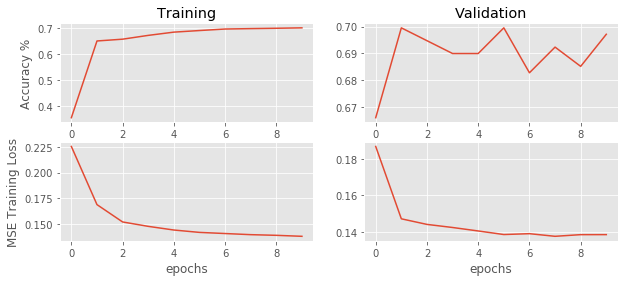

In [13]:
accuracy = 0 
mlp_proba_3 = []       # 创建一个list存储每份数据得到的yhat
for k, (train, test) in enumerate(kfold):
    X_train = df.iloc[train]
    X_test = df.iloc[test]
    a, yhat = wide_deep_3([['Sex','Shucked_weight','Shell_weight'], ['Shucked_weight','Shell_weight']],X_train, X_test)
    accuracy += a 
    mlp_proba_3.append(yhat) 

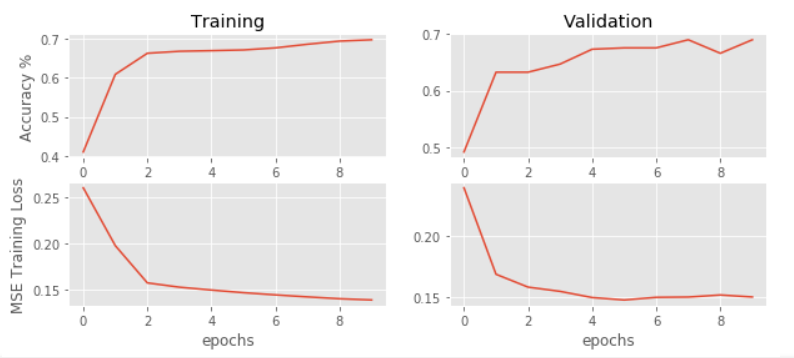
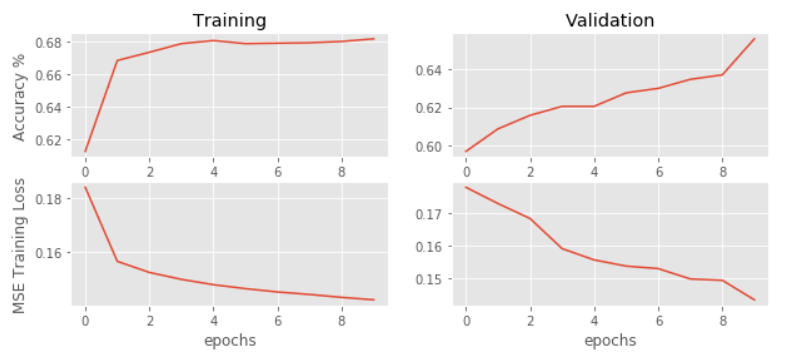
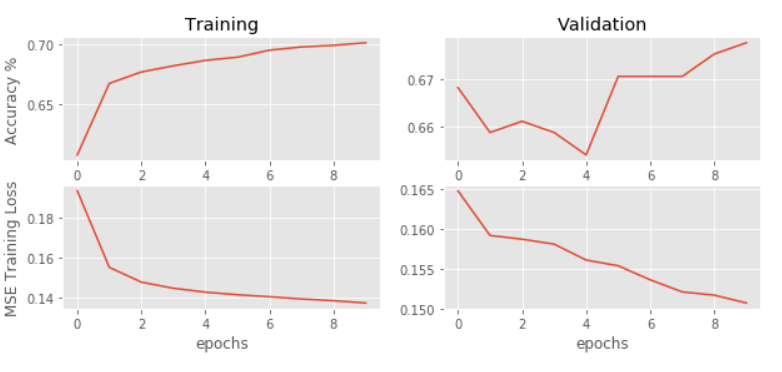
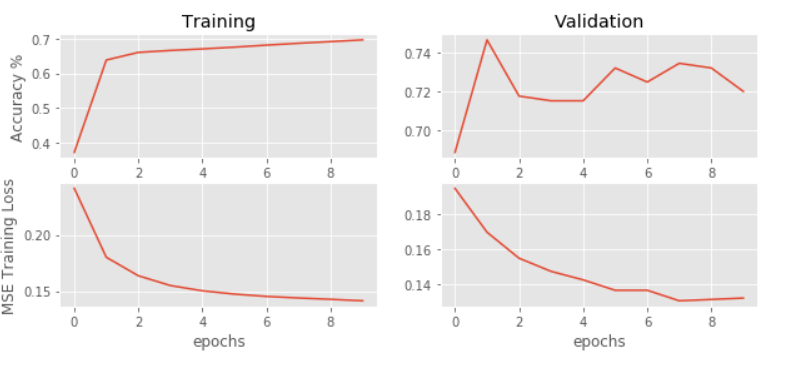
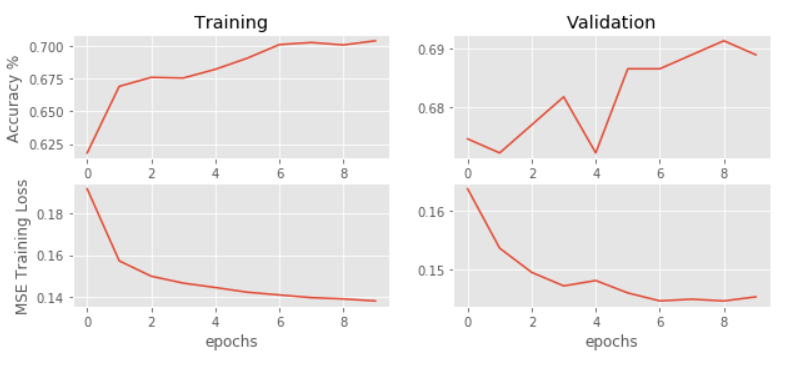
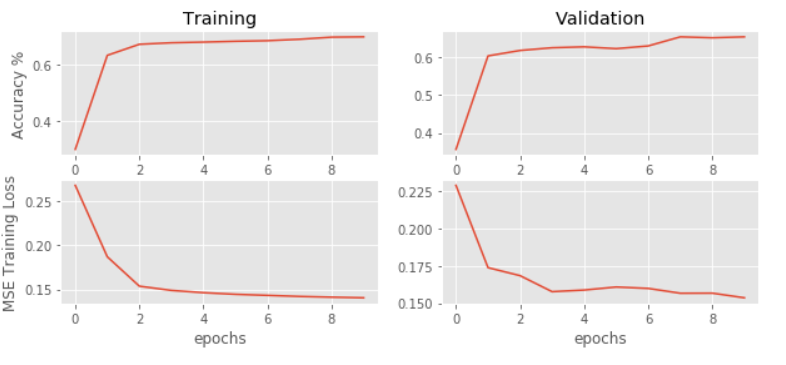
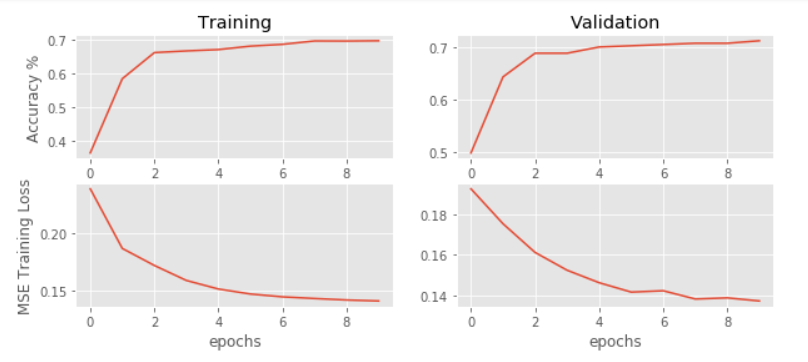
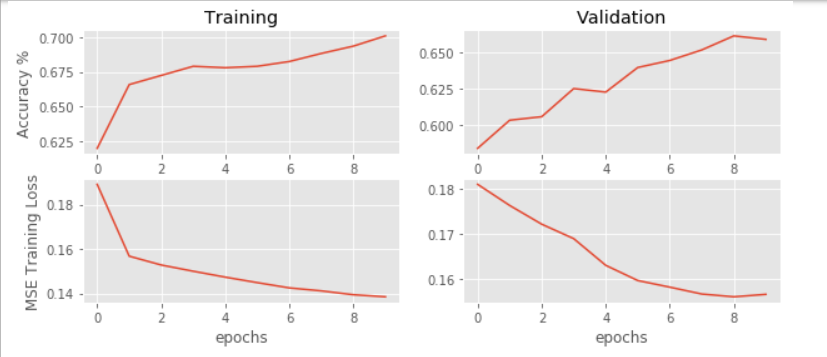
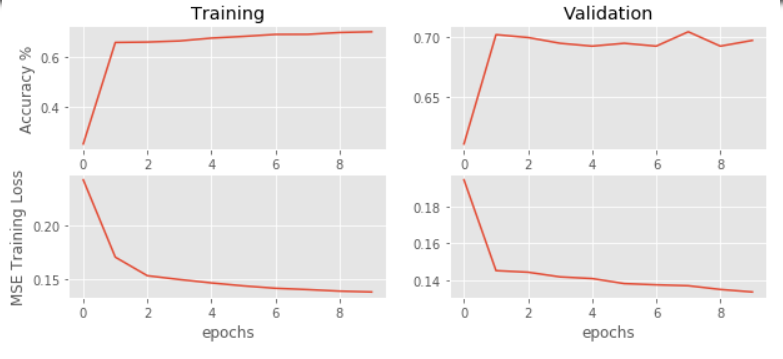
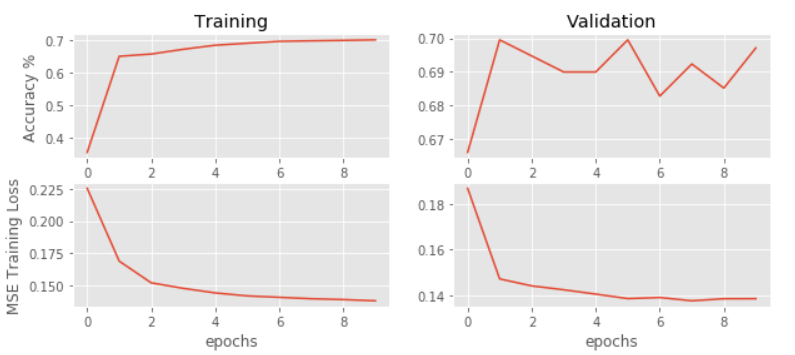

In [14]:
accuracy = accuracy / 10
accuracy

0.63710969856986366

According to the comparison between 4 layers and 3 layers, 4 layers works better

# 3.Comparsion with MLP

In [15]:
#load the Abalone dataset
df = pd.read_excel('D:/Abalone.xlsx')
# create numrical indicator for each feature
# '0': 1-8 infant   '1': 9-12 meature   '2': 13+ old
df['Rings'] = pd.cut(df['Rings'],[0,8,12,1e6],
                                 labels=['1-8','9-12','13+']) # this creates a new variable
df.Rings.replace(to_replace = ['1-8','9-12', '13+'],
                 value = range(3), inplace = True)
# '0':   light   '1': medium   '2': heavy   '3':very heavy
df['Shucked_weight'] = pd.cut(df['Shucked_weight'],[0,0.2,0.4,0.7,2],
                                 labels=['light','medium','heavy','very heavy']) 
df.Shucked_weight.replace(to_replace = ['light','medium','heavy','very heavy'],value = range(4), inplace = True)
# '0':   light   '1': medium   '2': heavy   '3':very heavy
df['Shell_weight'] = pd.cut(df['Shell_weight'],[0,0.15,0.3,0.5,2],
                                 labels=['light','medium','heavy','very heavy']) 
df.Shell_weight.replace(to_replace = ['light','medium','heavy','very heavy'],value = range(4), inplace = True)
# convert sex to numrical indicator
# F: female, M: Male, I:infant(the infant abalone haven't form the feature of sex)
df['Sex'] = df.Sex.replace(to_replace=['F','M','I'],value = range(3))

In [16]:
from sklearn.metrics import make_scorer,f1_score

# make f1 micro our scorer
scorer = make_scorer(f1_score, average='micro', pos_label=1, greater_is_better = True)

In [21]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(50, ), random_state=1)
mlp_proba_2 = []
mlp_features = ['Sex','Length','Diameter','Height','Whole_weight','Shucked_weight','Viscera_weight','Shell_weight']
for k, (train, test) in enumerate(kfold):
   
    df_tr = df.iloc[train]
    df_te = df.iloc[test]
    mlp.fit(df_tr[mlp_features].values, df_tr['Rings'].values)
    yhat = mlp.predict(df_te[mlp_features].values)
    yhat =  np_utils.to_categorical(yhat)
    mlp_proba_2.append(yhat)

In [22]:
######          Wide and Deep
from sklearn.metrics import confusion_matrix
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_curve, auc
from scipy import interp

nclass = 3

def roc_clf(proba_=mlp_proba_4):              # 直接传入yhat
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    
    for i, (train, test) in enumerate(kfold):
        df_tr = df.iloc[train]
        df_te = df.iloc[test]
        y_train = df_tr.Rings.values
        y_test = df_te.Rings.values
        
        perclass_mean_tpr = 0.0
        roc_auc = 0
        classes = np.unique(y_train)
        
        probas = proba_[i]
        
        for j in classes:
            fpr, tpr, thresholds = roc_curve(y_test,
                                         probas[:, j],
                                         pos_label=j)
            perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
            perclass_mean_tpr[0] = 0.0
            roc_auc += auc(fpr, tpr)
        
        perclass_mean_tpr /= len(classes)
        mean_tpr += perclass_mean_tpr
        roc_auc /= len(classes)
        plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))
    
    mean_tpr /= 10
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr,mean_tpr,'k-',lw=2,label='Total Mean ROC (area = %0.2f)'
                   % (mean_auc))
    plt.legend(loc='best')
    plt.grid()
    plt.show()

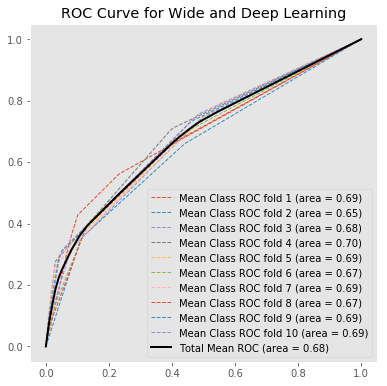

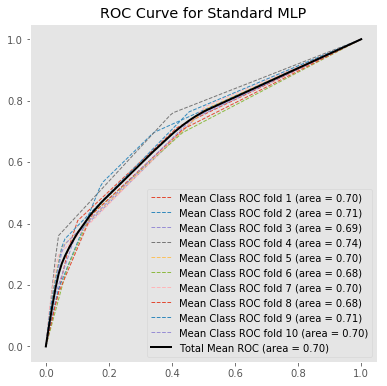

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 13))
gs = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[:2, :2])
ax1 = plt.title("ROC Curve for Wide and Deep Learning")
roc_1 = roc_clf(mlp_proba_3)
plt.figure(figsize=(13, 13))
ax2 = plt.subplot(gs[:2, :2])
ax2 = plt.title("ROC Curve for Standard MLP")
roc_2 = roc_clf(mlp_proba_2)

# 4.Exceptional Work

TensorBoard includes the Embedding Projector, a tool that lets you interactively visualize embeddings. This tool can read embeddings from model and render them in two or three dimensions. And the Embedding Projector support t-SNE to reduce the dimensionality of a data set.So here I choose TensorBoard to complete this part.

1.Setup a 2D tensor that holds embedding(s).

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from tensorflow.contrib.tensorboard.plugins import projector

LOG_DIR = 'abasample'
NAME_TO_VISUALIZE_VARIABLE = "abaembedding"
TO_EMBED_COUNT = 500
path_for_aba_metadata =  os.path.join(LOG_DIR,'metadata.tsv')
aba= df
embedding_var = tf.Variable(embedding,name=NAME_TO_VISUALIZE_VARIABLE)# embedding 的结果
summary_writer = tf.summary.FileWriter(LOG_DIR)

2.Create the embedding projector

In [ ]:
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# Specify where you find the metadata
embedding.metadata_path = path_for_aba_metadata #'metadata.tsv'

# Say that you want to visualize the embeddings
projector.visualize_embeddings(summary_writer, config)

3.Saving the data

In [29]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), 1)

'abasample\\model.ckpt-1'

4.Save the metadata

In [ ]:
with open(path_for_aba_metadata,'w') as f:
    f.write("Index\tLabel\n")
    for index,label in enumerate(batch_ys):
        f.write("%d\t%d\n" % (index,label))

5.Run and visualize.

Open the terminal, input command below, copy the link, then we can get the the visual result in the browser.

In [ ]:
tensorboard --logdir=abasample’

Ideally,I can get a similar result as below.The default method is PCA. And I can choose T-SNE to get the result, and analyze it.


Tensorboard is a powerful API. After reading the Tensorboard Embedding Tutorial, I know the basic steps to complete this part,it's a pity that in the limited time, I haven't finished debugging.

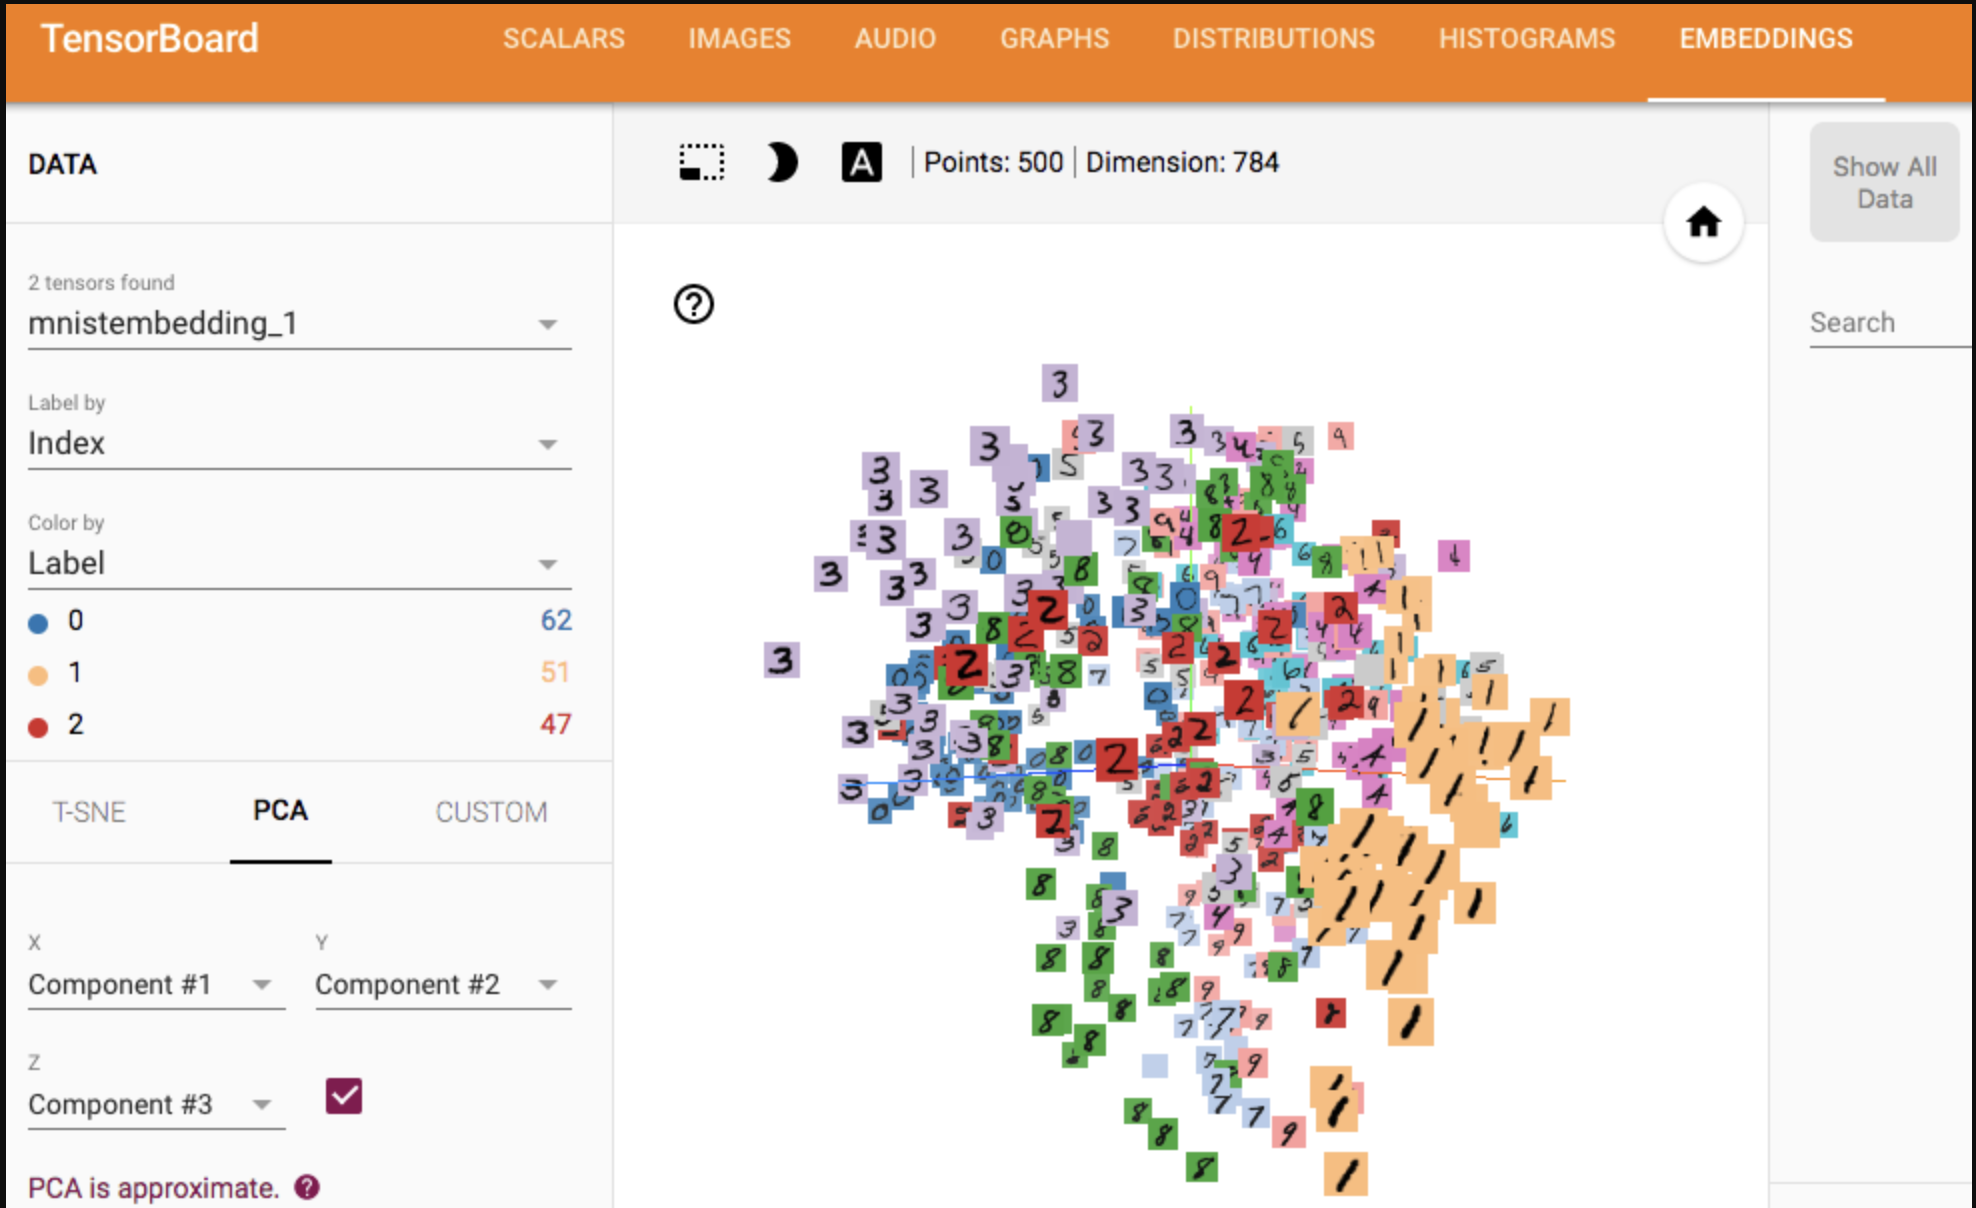

# Reference

1.https://www.tensorflow.org/programmers_guide/embedding

2.https://github.com/rmeertens/Simplest-Tensorflow-Tensorboard-MNIST-Embedding-Visualisation/blob/master/Minimal%20example%20embeddings.ipynb

3.https://github.com/eclarson/MachineLearningNotebooks